In [1]:
import os
import shutil

import pyemu
import pandas as pd
import matplotlib.pyplot as plt

from lumpyrem import run

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
bins_pth = os.path.join('..', 'bins', 'win') if 'nt' in os.name else os.path.join('..', 'bins', 'linux') # Binaries
olproc_input_pth = os.path.join('..', 'data', 'olproc_input') # Measured data (field obs)

In [3]:
org_model_ws = os.path.join('..', 'temp_ml_param_2d')
os.listdir(org_model_ws)

['pest', 'runmodel']

In [4]:
tmp_model_ws = os.path.join('..', 'temp_ml_obs_2d') # Safe to delete
if os.path.exists(tmp_model_ws):
    shutil.rmtree(tmp_model_ws)
shutil.copytree(org_model_ws,tmp_model_ws)
os.listdir(tmp_model_ws)

['pest', 'runmodel']

In [5]:
postproc_ws = os.path.join(tmp_model_ws, 'runmodel', 'postproc')
if not os.path.exists(postproc_ws):
    os.mkdir(postproc_ws)

In [6]:
os.listdir(olproc_input_pth)

['accumulated_eosine.ssf',
 'accumulated_fluorescein.ssf',
 'accumulated_rwt.ssf',
 'accumulated_srb.ssf',
 'dh-head-stage1.ssf',
 'obs-gage1.ssf',
 'obs-gage2.ssf',
 'obs-head-all.ssf',
 'obs-head.ssf',
 'obs-head1.ssf',
 'obs-head2.ssf',
 'obs-head3.ssf',
 'obs-stage1.ssf',
 'readme.md']

In [7]:
gage1_meas = pyemu.utils.smp_utils.smp_to_dataframe(os.path.join(olproc_input_pth, 'obs-gage1.ssf'))
gage2_meas = pyemu.utils.smp_utils.smp_to_dataframe(os.path.join(olproc_input_pth, 'obs-gage2.ssf'))

In [8]:
gage2_meas

,datetime,name,value
0,2018-11-07,GAGE-2,7092.16
1,2018-11-08,GAGE-2,8148.60
2,2018-11-09,GAGE-2,7871.40
3,2018-11-10,GAGE-2,8011.80
4,2018-11-11,GAGE-2,9612.00
...,...,...,...
416,2019-12-28,GAGE-2,26121.60
417,2019-12-29,GAGE-2,27442.80
418,2019-12-30,GAGE-2,35524.80
419,2019-12-31,GAGE-2,36986.40


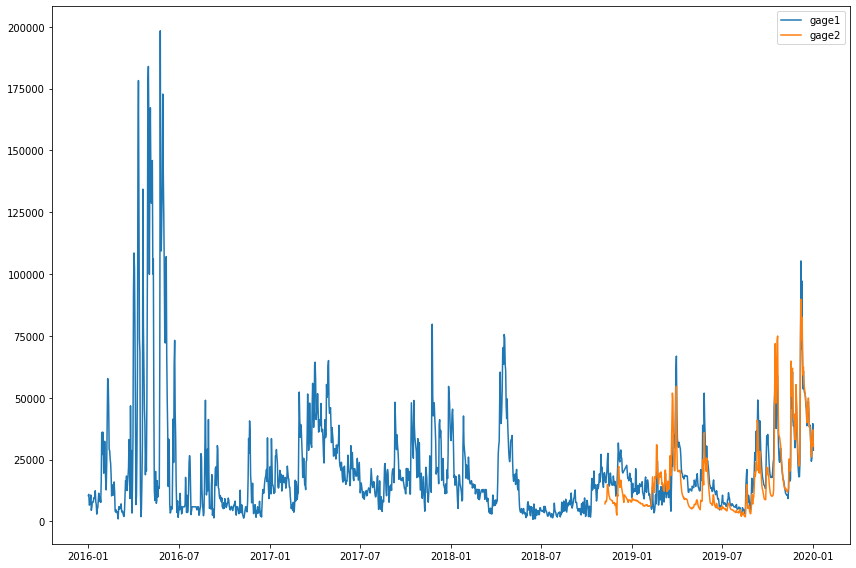

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))

x, y, = gage1_meas.datetime, gage1_meas.value
ax.plot(x, y, label='gage1')

x2, y2, = gage2_meas.datetime, gage2_meas.value
ax.plot(x2, y2, label='gage2')

plt.legend()
plt.tight_layout()

In [10]:
for file in os.listdir(olproc_input_pth):
    if not 'readme' in file:
        shutil.copyfile(os.path.join(olproc_input_pth, file), os.path.join(postproc_ws, file))

In [11]:
def write_script(filename, lines):

    with open(filename, 'a') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

In [12]:
write_script(os.path.join(postproc_ws, 'olproc.in'), [
'''
START GENERAL
  date_format        = dd/mm/yyyy

  # the 1st timestep is a 1-day steady state stress period
  # the subsequent transient stress period starts on 01/01/2016 
  model_start_date   = 31/12/2015
  model_start_time   = 00:00:00
  
  # MODFLOW6 time-step units are setup as day.
  model_time_units   = days

  # Set the History Matching Window
  history_match_start_date  = 01/01/2016
END GENERAL

START MEAS_SSF_FILES
  # Read the head measurements for layers 1, 2 and 3
  file = obs-head-all.ssf      group=heads   use_abs=yes  use_diff=yes
  
  # Read the stage measurements for creek Örbäcken in layer 1
  file = obs-stage1.ssf     group=stage1   use_abs=yes  use_diff=yes
  
  # Read the gage 1 measurements for creek Örbäcken in layer 1
  file = obs-gage1.ssf     group=gage1   use_abs=yes  use_diff=yes
  
  # Read the gage 2 measurements for creek Örbäcken in layer 1
  file = obs-gage2.ssf     group=gage2   use_abs=yes  use_diff=yes
  
  # headstagediff is the difference between head and stage in layer 1 at the same site
  file = dh-head-stage1.ssf   group=dh_hedstg use_abs=yes use_diff=no
END MEAS_SSF_FILES

START MF6_OBS_FILES
  file = ../model/head.obs.csv
  file = ../model/sfr_stage.obs.csv
  file = ../model/sfr_gage.obs.csv
END MF6_OBS_FILES

START OUTPUT
  partial_pest_control_file = partial1.pst
  model_batch_file          = runmodel.bat
  obs_ssf_folder            = .\obs_files
END OUTPUT

START WEIGHTS
    # PERIOD OF UNRELIABLE DATA
    # Set weights for gage1 during specific period
    name = gage1 type=abs weight= 0.0 &
    date1=01/01/2016 time1 = 00:00:00 &
    date2=01/07/2016 time2 = 23:59:59
    

    # Set weights for gage1 during specific period
    name = gage1 type=diff weight= 0.0 &
    date1=01/01/2016 time1 = 00:00:00 &
    date2=01/07/2016 time2 = 23:59:59
    
END WEIGHTS

START SECONDARY_MODEL_OUTCOMES  
  DH-NI15-O1 = "NI15-O1" - "NI15-O1-STG"
  DH-NI15-O44 = "NI15-O44" - "NI15-O44-STG"
  DH-NI15-O46 = "NI15-O46" - "NI15-O46-STG"
  DH-NI15-O47 = "NI15-O47" - "NI15-O47-STG"
  DH-NI15-O48 = "NI15-O48" - "NI15-O48-STG"
END SECONDARY_MODEL_OUTCOMES 
'''
])

In [13]:
obs_ssf_folder = os.path.join(postproc_ws, 'obs_files')
if os.path.exists(obs_ssf_folder):
    shutil.rmtree(obs_ssf_folder)
    os.mkdir(obs_ssf_folder)
else:
    os.mkdir(obs_ssf_folder)

Add a return statement to dynamically capture NOBS, NOBSGP, and NINSFILE:

In [14]:
def run_process_stdout(process, path=False, commands=[], print_output=True):
    import os
    import subprocess
    """This calls a process and then executes a list of commands.

    Parameters
    ----------
    process : str
        The name of the process to execute.
    path : str, optional
        path in which to execute commands. False (default) result sin commans being executed in current working directory.
    commands : list of str
        sequence of commands to pass to the process.
    print_output : bool, optional
            True, process output is printed. False, it is not.
        """

    if path == False:
        path = os.getcwd()

    owd = os.getcwd()
    os.chdir(path)

    p = subprocess.run([process], stdout=subprocess.PIPE,
            input='\n'.join(map(str, commands))+'\n', encoding='ascii')

    if print_output==True:
            print(p.stdout)
    os.chdir(owd)
    return p.stdout

In [15]:
# run OLPROC
olp_construct = run_process_stdout(
    'olproc',
    path=postproc_ws,
    commands=['olproc.in', 0] # Run OLPROC in postprocessor mode
)


 OLPROC Version 1.0. Watermark Numerical Computing.

 Enter name of OLPROC control file:  Enter OLPROC mode index [0 or 1]:  - file olproc.in read ok.
 - file ../model/head.obs.csv read ok.
 - file ../model/sfr_stage.obs.csv read ok.
 - file ../model/sfr_gage.obs.csv read ok.
 - file obs-head-all.ssf read ok.
 - file obs-stage1.ssf read ok.
 - file obs-gage1.ssf read ok.
 - file obs-gage2.ssf read ok.
 - file dh-head-stage1.ssf read ok.
 - model observation equations evaluated ok.
 - file .\obs_files\o_obs-head-all_ssf.ssf written ok.
 - file m_obs-head-all_ssf.ins written ok.
 - file m_obs-head-all_ssf.ssf written ok.
 - file .\obs_files\o_obs-stage1_ssf.ssf written ok.
 - file m_obs-stage1_ssf.ins written ok.
 - file m_obs-stage1_ssf.ssf written ok.
 - file .\obs_files\o_obs-gage1_ssf.ssf written ok.
 - file m_obs-gage1_ssf.ins written ok.
 - file m_obs-gage1_ssf.ssf written ok.
 - file .\obs_files\o_obs-gage2_ssf.ssf written ok.
 - file m_obs-gage2_ssf.ins written ok.
 - file m_obs

In [16]:
nobs = olp_construct.split('\n')[-4].split()[-1]
nobsgp = olp_construct.split('\n')[-3].split()[-1]
ninsfile = olp_construct.split('\n')[-2].split()[-1]
print(nobs)
print(nobsgp)
print(ninsfile)

27084
9
9


Create dummy measurements for the prediction observation (is this needed?) using the uncalibrated model output:

In [17]:
#ml_computed_leakage_pt1 = os.path.join(tmp_model_ws, 'runmodel', 'model', 'sfr_pred_leak_pt1.obs.csv')

In [18]:
#dummy1 = pd.read_csv(ml_computed_leakage_pt1, index_col=0)
#dummy1.head()

In [19]:
#sp_start = pd.to_datetime('2016-01-01') + pd.to_timedelta(dummy1.index.values,unit='d')

In [20]:
#dummy1.insert(0, 'datetime', sp_start)

In [21]:
#dummy1 = dummy1.reset_index(drop=True)

In [22]:
#dummy1.head()

In [23]:
#dummy1 = dummy1.melt(id_vars=['datetime'])
#dummy1

In [24]:
#dummy1.rename(columns={'variable': 'name'}, inplace=True)

In [25]:
#pyemu.utils.smp_utils.dataframe_to_smp(
#    dummy1,
#    os.path.join(postproc_ws, 'pred-leak-pt1.ssf'),
#    name_col='name',
#    datetime_col='datetime',
#    value_col='value',
#    datetime_format='dd/mm/yyyy',
#    value_format='{0:15.6E}',
#    max_name_len=12
#)

In [26]:
#ml_computed_leakage_pt2 = os.path.join(tmp_model_ws, 'runmodel', 'model', 'sfr_pred_leak_pt2.obs.csv')
#dummy2 = pd.read_csv(ml_computed_leakage_pt2, index_col=0)
#dummy2.head()

In [27]:
#dummy2.insert(0, 'datetime', sp_start)
#dummy2 = dummy2.reset_index(drop=True)
#dummy2 = dummy2.melt(id_vars=['datetime'])
#dummy2.rename(columns={'variable': 'name'}, inplace=True)

In [28]:
#dummy2.head()

In [29]:
#pyemu.utils.smp_utils.dataframe_to_smp(
#    dummy2,
#    os.path.join(postproc_ws, 'pred-leak-pt2.ssf'),
#    name_col='name',
#    datetime_col='datetime',
#    value_col='value',
#    datetime_format='dd/mm/yyyy',
#    value_format='{0:15.6E}',
#    max_name_len=12
#)

Create dummy:

In [30]:
ml_computed_leakage = os.path.join(tmp_model_ws, 'runmodel', 'model', 'sfr_pred_leak.obs.csv')

In [31]:
dummy = pd.read_csv(ml_computed_leakage, index_col=0)
dummy.head()

,LK-70,LK-140,LK-210
time,,,
0.000000,0.000269,-60.846530,-58.973286
7.019231,0.000269,-61.477666,-60.057965
14.038462,0.000556,-61.436255,-59.919862
21.057692,0.000004,-60.419109,-57.885075
28.076923,0.001096,-60.026314,-57.680247


In [32]:
sp_start = pd.to_datetime('2016-01-01') + pd.to_timedelta(dummy.index.values,unit='d')

In [33]:
dummy.insert(0, 'datetime', sp_start)
dummy = dummy.reset_index(drop=True)
dummy = dummy.melt(id_vars=['datetime'])
dummy.rename(columns={'variable': 'name'}, inplace=True)

In [34]:
pyemu.utils.smp_utils.dataframe_to_smp(
    dummy,
    os.path.join(postproc_ws, 'pred-leak.ssf'),
    name_col='name',
    datetime_col='datetime',
    value_col='value',
    datetime_format='dd/mm/yyyy',
    value_format='{0:15.6E}',
    max_name_len=12
)

In [35]:
write_script(os.path.join(postproc_ws, 'olproc-pred.in'), [
'''
START GENERAL
  date_format        = dd/mm/yyyy

  # the 1st timestep is a 1-day steady state stress period
  # the subsequent transient stress period starts on 01/01/2016 
  model_start_date   = 31/12/2015
  model_start_time   = 00:00:00
  
  # MODFLOW6 time-step units are setup as day.
  model_time_units   = days

  # Set the History Matching Window
  history_match_start_date  = 01/01/2016
END GENERAL

START MEAS_SSF_FILES
  file = pred-leak.ssf  group=pleak use_abs=yes use_diff=no 
#  file = pred-leak-pt1.ssf  group=pleak use_abs=yes use_diff=no 
#  file = pred-leak-pt2.ssf  group=pleak use_abs=yes use_diff=no 
END MEAS_SSF_FILES

START MF6_OBS_FILES
file = ../model/sfr_pred_leak.obs.csv
#  file = ../model/sfr_pred_leak_pt1.obs.csv
#  file = ../model/sfr_pred_leak_pt2.obs.csv
END MF6_OBS_FILES

START OUTPUT
  partial_pest_control_file = partial2.pst
  model_batch_file          = runmodel.bat
  obs_ssf_folder            = .\obs_files
END OUTPUT

# START SECONDARY_MODEL_OUTCOMES
# this is where reaches are assigned?
# END SECONDARY_MODEL_OUTCOMES

START WEIGHTS              
  name = pleak type=abs weight=0
END WEIGHTS

'''
])

In [36]:
# run OLPROC
olp_pred_construct = run_process_stdout(
    'olproc',
    path=postproc_ws,
    commands=['olproc-pred.in', 0] # Run OLPROC in postprocessor mode
)


 OLPROC Version 1.0. Watermark Numerical Computing.

 Enter name of OLPROC control file:  Enter OLPROC mode index [0 or 1]:  - file olproc-pred.in read ok.
 - file ../model/sfr_pred_leak.obs.csv read ok.
 - file pred-leak.ssf read ok.
 - file .\obs_files\o_pred-leak_ssf.ssf written ok.
 - file m_pred-leak_ssf.ins written ok.
 - file m_pred-leak_ssf.ssf written ok.
 - file partial2.pst written ok.
 
   Number of observations [NOBS]         = 624
   Number of observation groups [NOBSGP] = 1
   Number of instruction files [NINSFLE] = 1



In [37]:
nobs_pred = olp_pred_construct.split('\n')[-4].split()[-1]
nobsgp_pred = olp_pred_construct.split('\n')[-3].split()[-1]
ninsfile_pred = olp_pred_construct.split('\n')[-2].split()[-1]
print(nobs_pred)
print(nobsgp_pred)
print(ninsfile_pred)

624
1
1


Add obs, obsgp and ninsfile from both the history-matching dataset and the prediction datasets:

In [38]:
nobs_tot = int(nobs) + int(nobs_pred)
nobsgp_tot = int(nobsgp) + int(nobsgp_pred)
ninsfile_tot = int(ninsfile) + int(ninsfile_pred)
print(nobs_tot)
print(nobsgp_tot)
print(ninsfile_tot)

27708
10
10


Copy all the instruction files to the pest\instruction folder:

In [39]:
insfiles = [i for i in os.listdir(postproc_ws) if '.ins' in i]

In [40]:
instruction_ws = os.path.join(tmp_model_ws, 'pest', 'instruction')

In [41]:
for file in insfiles:
    shutil.copyfile(os.path.join(postproc_ws, file), os.path.join(instruction_ws, file))

### Concatenate pestfiles

In [42]:
pest_ws = os.path.join(tmp_model_ws, 'pest')

In [43]:
with open(os.path.join(pest_ws, 'calib0.pst'), 'r') as file:
    calib0_pstfile = file.readlines()

In [44]:
display(calib0_pstfile)

['pcf\n',
 '* control data\n',
 'restart estimation\n',
 '1628 0 19 0 0\n',
 '   12  0    single  point\n',
 ' 10.0  -3.0  0.3  0.03  10  lamforgive\n',
 ' 10.0  10.0  0.001\n',
 ' 0.1\n',
 ' 50  0.005  4  4  0.005  4\n',
 ' 0  0  0\n',
 '* singular value decomposition\n',
 '1\n',
 '  5000  5e-7\n',
 '0\n',
 '* parameter groups\n',
 'lrgblu relative 0.015 0.0 switch 2 parabolic\n',
 'lrggre relative 0.015 0.0 switch 2 parabolic\n',
 'lrrch relative 0.015 0.0 switch 2 parabolic\n',
 'lrgred relative 0.015 0.0 switch 2 parabolic\n',
 'lrgyel relative 0.015 0.0 switch 2 parabolic\n',
 'ghbmul relative 0.015 0.0 switch 2 parabolic\n',
 'ghbblu relative 0.015 0.0 switch 2 parabolic\n',
 'ghbgre relative 0.015 0.0 switch 2 parabolic\n',
 'ghbred relative 0.015 0.0 switch 2 parabolic\n',
 'ghbyel relative 0.015 0.0 switch 2 parabolic\n',
 'khpp relative 0.015 0.0 switch 2 parabolic\n',
 'sfrinf relative 0.015 0.0 switch 2 parabolic\n',
 'sfrman relative 0.015 0.0 switch 2 parabolic\n',
 'sfrb

In [45]:
with open(os.path.join(postproc_ws, 'partial1.pst'), 'r') as file:
    partial_pstfile_obs1 = file.readlines()

In [46]:
display(partial_pstfile_obs1)

['* observation groups\n',
 'heads\n',
 'stage1\n',
 'gage1\n',
 'gage2\n',
 'dh_hedstg\n',
 'heads_d\n',
 'stage1_d\n',
 'gage1_d\n',
 'gage2_d\n',
 '* observation data\n',
 ' b2-1_1                 137.053540            1.000000          heads\n',
 ' b2-1_2                 137.048832            1.000000          heads\n',
 ' b2-1_3                 137.053302            1.000000          heads\n',
 ' b2-1_4                 137.053829            1.000000          heads\n',
 ' b2-1_5                 137.055800            1.000000          heads\n',
 ' b2-1_6                 137.058044            1.000000          heads\n',
 ' b2-1_7                 137.065114            1.000000          heads\n',
 ' b2-1_8                 137.067272            1.000000          heads\n',
 ' b2-1_9                 137.073815            1.000000          heads\n',
 ' b2-1_10                137.070994            1.000000          heads\n',
 ' b2-1_11                137.071470            1.000000          

In [47]:
ppf_obs_ogp_strt = partial_pstfile_obs1.index('* observation groups\n') + 1
ppf_obs_ogp_stop = partial_pstfile_obs1.index('* observation data\n')

In [48]:
ppf_obs_ogp1 = partial_pstfile_obs1[ppf_obs_ogp_strt:ppf_obs_ogp_stop] #partial pestfile obsgrp
display(ppf_obs_ogp1)

['heads\n',
 'stage1\n',
 'gage1\n',
 'gage2\n',
 'dh_hedstg\n',
 'heads_d\n',
 'stage1_d\n',
 'gage1_d\n',
 'gage2_d\n']

make temp copy of `calib0.pst`:

In [49]:
calib0_pstfile_temp = calib0_pstfile[:]

In [50]:
calib0_calib_ogp_strt = calib0_pstfile_temp.index('* observation groups\n') + 1
calib0_calib_ogp_stop = calib0_pstfile_temp.index('* observation data\n')

In [51]:
calib0_pstfile_temp[calib0_calib_ogp_strt:calib0_calib_ogp_stop] = ppf_obs_ogp1

obsgroups are now inserted at the correct location:

In [52]:
calib0_pstfile_temp[-30:]

['sypp219 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 'sypp220 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 'sypp221 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 'sypp222 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 'sypp223 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 '* observation groups\n',
 'heads\n',
 'stage1\n',
 'gage1\n',
 'gage2\n',
 'dh_hedstg\n',
 'heads_d\n',
 'stage1_d\n',
 'gage1_d\n',
 'gage2_d\n',
 '* observation data\n',
 '* model command line\n',
 '* model input/output\n',
 '.\\template\\pps_cond.tpl ..\\runmodel\\preproc\\pps_cond.dat\n',
 '.\\template\\pps_sto.tpl ..\\runmodel\\preproc\\pps_sto.dat\n',
 '.\\template\\pps_sfr.tpl ..\\runmodel\\preproc\\pps_sfr.dat\n',
 '.\\template\\ghbpp.tpl ..\\runmodel\\preproc\\ghbpp.dat\n',
 '.\\template\\ghb_multiplier.tpl ..\\runmodel\\preproc\\ghb_multiplier.py\n',
 '.\\template\\sfr_rtpmodel.tpl ..\\runmodel\\preproc\\sfr_rtpmodel.py\n',
 '.\\template\\sfr_reach1_inflow.tpl ..\\runmodel\\model\\sfr_reach1_inflow.ts\n',
 '.\\template

Moving on to obsdata (calibration dataset):

In [53]:
ppf1_obs_odt_strt = partial_pstfile_obs1.index('* observation data\n') + 1
ppf1_obs_odt_stop = partial_pstfile_obs1.index('* model command line\n')

In [54]:
ppf1_obs_odt = partial_pstfile_obs1[ppf1_obs_odt_strt:ppf1_obs_odt_stop]

In [55]:
ppf1_calib_odt_strt = calib0_pstfile_temp.index('* observation data\n') + 1
ppf1_calib_odt_stop = calib0_pstfile_temp.index('* model command line\n')

In [56]:
#calib0_pstfile_temp.insert(calib0_pstfile_temp.index('* observation data\n') + 1, ppf1_obs_odt[0])

In [57]:
calib0_pstfile_temp[ppf1_calib_odt_strt:ppf1_calib_odt_stop] = ppf1_obs_odt

In [58]:
calib0_pstfile_temp[-30:]

[' gage-2_d404            45401.2400            100.0000          gage2_d\n',
 ' gage-2_d405            43410.4400            100.0000          gage2_d\n',
 ' gage-2_d406            40823.8400            100.0000          gage2_d\n',
 ' gage-2_d407            38660.2400            100.0000          gage2_d\n',
 ' gage-2_d408            32801.2400            100.0000          gage2_d\n',
 ' gage-2_d409            37450.6400            100.0000          gage2_d\n',
 ' gage-2_d410            38806.0400            100.0000          gage2_d\n',
 ' gage-2_d411            42805.6400            100.0000          gage2_d\n',
 ' gage-2_d412            36813.4400            100.0000          gage2_d\n',
 ' gage-2_d413            31175.8400            100.0000          gage2_d\n',
 ' gage-2_d414            31242.4400            100.0000          gage2_d\n',
 ' gage-2_d415            27905.2400            100.0000          gage2_d\n',
 ' gage-2_d416            23313.4400            100.0000        

In [59]:
calib0_pstfile_temp[calib0_pstfile_temp.index('* observation data\n'):]

['* observation data\n',
 ' b2-1_1                 137.053540            1.000000          heads\n',
 ' b2-1_2                 137.048832            1.000000          heads\n',
 ' b2-1_3                 137.053302            1.000000          heads\n',
 ' b2-1_4                 137.053829            1.000000          heads\n',
 ' b2-1_5                 137.055800            1.000000          heads\n',
 ' b2-1_6                 137.058044            1.000000          heads\n',
 ' b2-1_7                 137.065114            1.000000          heads\n',
 ' b2-1_8                 137.067272            1.000000          heads\n',
 ' b2-1_9                 137.073815            1.000000          heads\n',
 ' b2-1_10                137.070994            1.000000          heads\n',
 ' b2-1_11                137.071470            1.000000          heads\n',
 ' b2-1_12                137.078166            1.000000          heads\n',
 ' b2-1_13                137.068750            1.000000       

Obsgrp (prediction dataset):

In [60]:
with open(os.path.join(postproc_ws, 'partial2.pst'), 'r') as file:
    partial_pstfile_obs2 = file.readlines()

In [61]:
ppf2_obs_ogp_strt = partial_pstfile_obs2.index('* observation groups\n') + 1
ppf2_obs_ogp_stop = partial_pstfile_obs2.index('* observation data\n')

In [62]:
ppf2_obs_ogp = partial_pstfile_obs2[ppf2_obs_ogp_strt:ppf2_obs_ogp_stop]

In [63]:
ppf2_obs_ogp

['pleak\n']

Insert at last position of observation groups (which is one position above * observation data):

In [64]:
calib0_pstfile_temp.insert(calib0_pstfile_temp.index('* observation data\n'), ppf2_obs_ogp[0])

In [65]:
calib0_pstfile_temp[calib0_pstfile_temp.index('* observation data\n')-30:]

['sypp205 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 'sypp206 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 'sypp207 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 'sypp208 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 'sypp209 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 'sypp210 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 'sypp211 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 'sypp212 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 'sypp213 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 'sypp214 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 'sypp215 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 'sypp216 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 'sypp217 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 'sypp218 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 'sypp219 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 'sypp220 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 'sypp221 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 'sypp222 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 'sypp223 log factor 0.2 0.01 0.44 sypp 1.0 0.0\n',
 '* observat

Obsdata (prediction dataset):

In [66]:
ppf2_obs_odt_strt = partial_pstfile_obs2.index('* observation data\n') + 1
ppf2_obs_odt_stop = partial_pstfile_obs2.index('* model command line\n')

In [67]:
ppf2_obs_odt = partial_pstfile_obs2[ppf2_obs_odt_strt:ppf2_obs_odt_stop]

In [68]:
ppf2_obs_odt

[' lk-70_1                2.685572000E-04       0.000000          pleak\n',
 ' lk-70_2                2.693561000E-04       0.000000          pleak\n',
 ' lk-70_3                5.562669000E-04       0.000000          pleak\n',
 ' lk-70_4                3.628522000E-06       0.000000          pleak\n',
 ' lk-70_5                1.095998000E-03       0.000000          pleak\n',
 ' lk-70_6                6.518808000E-04       0.000000          pleak\n',
 ' lk-70_7                9.376625000E-04       0.000000          pleak\n',
 ' lk-70_8                2.285675000E-04       0.000000          pleak\n',
 ' lk-70_9                3.014966000E-04       0.000000          pleak\n',
 ' lk-70_10               2.544810000E-04       0.000000          pleak\n',
 ' lk-70_11               8.582349000E-04       0.000000          pleak\n',
 ' lk-70_12               1.207252000E-05       0.000000          pleak\n',
 ' lk-70_13               1.321034000E-04       0.000000          pleak\n',
 ' lk-70_14 

Insert at last position of observation data (which is one position above * model command line):

In [69]:
lastrow = calib0_pstfile_temp.index('* model command line\n')

In [70]:
calib0_pstfile_temp[lastrow:lastrow] = ppf2_obs_odt

In [71]:
calib0_pstfile_temp[-50:]

[' lk-210_173             -54.1346500           0.000000          pleak\n',
 ' lk-210_174             -53.2014800           0.000000          pleak\n',
 ' lk-210_175             -53.6259900           0.000000          pleak\n',
 ' lk-210_176             -55.5978900           0.000000          pleak\n',
 ' lk-210_177             -57.3895200           0.000000          pleak\n',
 ' lk-210_178             -60.9167500           0.000000          pleak\n',
 ' lk-210_179             -65.4663400           0.000000          pleak\n',
 ' lk-210_180             -64.0793100           0.000000          pleak\n',
 ' lk-210_181             -60.6537200           0.000000          pleak\n',
 ' lk-210_182             -59.1708300           0.000000          pleak\n',
 ' lk-210_183             -58.5687400           0.000000          pleak\n',
 ' lk-210_184             -59.3796600           0.000000          pleak\n',
 ' lk-210_185             -61.4796300           0.000000          pleak\n',
 ' lk-210_18

### Update relative path names for each of the instruction and model output files

In [72]:
ml_io_start1 = partial_pstfile_obs1.index('* model input/output\n') + 2

In [73]:
prepend1, prepend2 = '.\\instruction\\', '..\\runmodel\\postproc\\'

In [74]:
new_ml_io1 = []
for i in partial_pstfile_obs1[ml_io_start1:]:
    for string, j in zip([prepend1, prepend2], i.split()):
        new_ml_io1.append(string + j)

In [75]:
new_ml_io1 = [' '.join(i) for i in zip(new_ml_io1[0::2], new_ml_io1[1::2])]

In [76]:
new_ml_io1 = [i+'\n' for i in new_ml_io1]

In [77]:
new_ml_io1

['.\\instruction\\m_obs-head-all_ssf.ins ..\\runmodel\\postproc\\m_obs-head-all_ssf.ssf\n',
 '.\\instruction\\m_obs-stage1_ssf.ins ..\\runmodel\\postproc\\m_obs-stage1_ssf.ssf\n',
 '.\\instruction\\m_obs-gage1_ssf.ins ..\\runmodel\\postproc\\m_obs-gage1_ssf.ssf\n',
 '.\\instruction\\m_obs-gage2_ssf.ins ..\\runmodel\\postproc\\m_obs-gage2_ssf.ssf\n',
 '.\\instruction\\m_dh-head-stage1_ssf.ins ..\\runmodel\\postproc\\m_dh-head-stage1_ssf.ssf\n',
 '.\\instruction\\m_obs-head-all_ssf_d.ins ..\\runmodel\\postproc\\m_obs-head-all_ssf_d.ssf\n',
 '.\\instruction\\m_obs-stage1_ssf_d.ins ..\\runmodel\\postproc\\m_obs-stage1_ssf_d.ssf\n',
 '.\\instruction\\m_obs-gage1_ssf_d.ins ..\\runmodel\\postproc\\m_obs-gage1_ssf_d.ssf\n',
 '.\\instruction\\m_obs-gage2_ssf_d.ins ..\\runmodel\\postproc\\m_obs-gage2_ssf_d.ssf\n']

In [78]:
ml_io_start2 = partial_pstfile_obs2.index('* model input/output\n') + 2

In [79]:
new_ml_io2 = []
for i in partial_pstfile_obs2[ml_io_start2:]:
    for string, j in zip([prepend1, prepend2], i.split()):
        new_ml_io2.append(string + j)

In [80]:
new_ml_io2

['.\\instruction\\m_pred-leak_ssf.ins',
 '..\\runmodel\\postproc\\m_pred-leak_ssf.ssf']

In [81]:
new_ml_io2 = [' '.join(i) for i in zip(new_ml_io2[0::2], new_ml_io2[1::2])]

In [82]:
new_ml_io2 = [i+'\n' for i in new_ml_io2]

In [83]:
new_ml_io2

['.\\instruction\\m_pred-leak_ssf.ins ..\\runmodel\\postproc\\m_pred-leak_ssf.ssf\n']

In [84]:
calib0_pstfile_temp = calib0_pstfile_temp + new_ml_io1 + new_ml_io2

In [85]:
calib0_pstfile_temp[-50:]

[' lk-210_183             -58.5687400           0.000000          pleak\n',
 ' lk-210_184             -59.3796600           0.000000          pleak\n',
 ' lk-210_185             -61.4796300           0.000000          pleak\n',
 ' lk-210_186             -62.3451500           0.000000          pleak\n',
 ' lk-210_187             -60.6978000           0.000000          pleak\n',
 ' lk-210_188             -59.9436300           0.000000          pleak\n',
 ' lk-210_189             -59.7798700           0.000000          pleak\n',
 ' lk-210_190             -64.0043900           0.000000          pleak\n',
 ' lk-210_191             -65.2607000           0.000000          pleak\n',
 ' lk-210_192             -62.6093200           0.000000          pleak\n',
 ' lk-210_193             -63.8250200           0.000000          pleak\n',
 ' lk-210_194             -64.7192900           0.000000          pleak\n',
 ' lk-210_195             -62.6230700           0.000000          pleak\n',
 ' lk-210_19

### Change NOBS, NOBSGP, NINSFLE

In [86]:
calib0_pstfile_temp

['pcf\n',
 '* control data\n',
 'restart estimation\n',
 '1628 0 19 0 0\n',
 '   12  0    single  point\n',
 ' 10.0  -3.0  0.3  0.03  10  lamforgive\n',
 ' 10.0  10.0  0.001\n',
 ' 0.1\n',
 ' 50  0.005  4  4  0.005  4\n',
 ' 0  0  0\n',
 '* singular value decomposition\n',
 '1\n',
 '  5000  5e-7\n',
 '0\n',
 '* parameter groups\n',
 'lrgblu relative 0.015 0.0 switch 2 parabolic\n',
 'lrggre relative 0.015 0.0 switch 2 parabolic\n',
 'lrrch relative 0.015 0.0 switch 2 parabolic\n',
 'lrgred relative 0.015 0.0 switch 2 parabolic\n',
 'lrgyel relative 0.015 0.0 switch 2 parabolic\n',
 'ghbmul relative 0.015 0.0 switch 2 parabolic\n',
 'ghbblu relative 0.015 0.0 switch 2 parabolic\n',
 'ghbgre relative 0.015 0.0 switch 2 parabolic\n',
 'ghbred relative 0.015 0.0 switch 2 parabolic\n',
 'ghbyel relative 0.015 0.0 switch 2 parabolic\n',
 'khpp relative 0.015 0.0 switch 2 parabolic\n',
 'sfrinf relative 0.015 0.0 switch 2 parabolic\n',
 'sfrman relative 0.015 0.0 switch 2 parabolic\n',
 'sfrb

In [87]:
calib0_pstfile_temp[3]

'1628 0 19 0 0\n'

In [88]:
temp_row = calib0_pstfile_temp[3].split()
display(temp_row)

['1628', '0', '19', '0', '0']

In [89]:
temp_row[1] = str(nobs_tot)
temp_row[-1] = f'{nobsgp_tot}\n'
display(temp_row)

['1628', '27708', '19', '0', '10\n']

In [90]:
new_row = ' '.join(temp_row)
display(new_row)

'1628 27708 19 0 10\n'

In [91]:
calib0_pstfile_temp[3] = new_row

In [92]:
temp_row = calib0_pstfile_temp[4].split()
display(temp_row)

['12', '0', 'single', 'point']

In [93]:
temp_row[1] = str(ninsfile_tot)
temp_row[-1] = f'{temp_row[-1]}\n'
display(temp_row)

['12', '10', 'single', 'point\n']

In [94]:
new_row = ' '.join(temp_row)
display(new_row)

'12 10 single point\n'

In [95]:
calib0_pstfile_temp[4] = new_row

In [96]:
calib0_pstfile_temp[:10]

['pcf\n',
 '* control data\n',
 'restart estimation\n',
 '1628 27708 19 0 10\n',
 '12 10 single point\n',
 ' 10.0  -3.0  0.3  0.03  10  lamforgive\n',
 ' 10.0  10.0  0.001\n',
 ' 0.1\n',
 ' 50  0.005  4  4  0.005  4\n',
 ' 0  0  0\n']

In [97]:
### Write new pestfile

In [98]:
with open(os.path.join(pest_ws, 'calib0.pst'), 'w') as file:
    for line in calib0_pstfile_temp:
        file.write(line)